In [1]:
import os
import sys
import yaml
import platform
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from IPython.display import display

from PIL import Image
import cv2
from pathlib import Path
from omegaconf import OmegaConf
from sklearn.preprocessing import StandardScaler

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from functools import reduce
from operator import or_

# Set plotting style
plt.style.use("seaborn-v0_8-paper")
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(1)

# Suppress warnings
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

spark = ( SparkSession.builder
            .appName("CheXpert-EDA")
            .getOrCreate()
    )

print("Python version: {}".format(platform.python_version()))
print("Torch version: {}".format(torch.__version__))
print("OpenCV version %s" %(cv2.__version__))


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/mafasa/miniconda3/envs/torch/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/mafasa/miniconda3/envs/torch/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/mafasa/miniconda3/envs/torch/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/mafasa/miniconda3/envs/torch/lib/python3.10/site-packages/traitlets/config/application.py", line 10

Python version: 3.10.19
Torch version: 2.2.1+cu121
OpenCV version 4.13.0


### What is CheXpert?
CheXpert is a large dataset of `chest X-rays` and competition for automated chext x-ray interpretation, which features uncertainty and radiologist-labeled reference standard evaluation sets.

### Why CheXpert?
Chest radiography is the most common imaging examination globally, critical for `screening`, `diagnosis`, and `management of many life threatening diseases`. Automated chest radiograph interpretation at the level of practicing radiologists could provide substantial benefit in many medical settings, from improved workflow prioritization and clinical decision support to large-scale screening and global population health initiatives. For progress in both development and validation of automated algorithms, we realized there was a need for a labeled dataset that (1) was large, (2) had strong reference standards, and (3) provided expert human performance metrics for comparison (`stanfordmlgroup.github.io/competitions/chexpert`)

In [ ]:
"""
Load raw data for EDA
"""
class LoadDataAssests:
    """Loads both the CSV and the associated img data"""
    def __init__(self, CONFIG_PATH: str = "../configs/chexpert.yaml"):

        self.config = self.load_config_file(CONFIG_PATH)
        # Accessing Paths
        self.csv_file_path = self.config.data.raw.CheXpert.csv_train
        self.img_data_path = self.config.data.raw.CheXpert.img_data

    def load_config_file(self, PATH: str):
        """ Load config file."""
        return OmegaConf.load(PATH)
    
    def get_csv_path(self):
        """Get CSV file path"""
        return self.csv_file_path

    def get_img_data_path(self):
        """Get Image data file path"""
        return self.img_data_path

CheXpert_data = LoadDataAssests()

# Load train CSV file
df_train = spark.read.csv(
    CheXpert_data.get_csv_path(),
    header=True,
    inferSchema=True
)

In [3]:
# Show sample data
df_train.show(5, truncate=False)

+---------------------------------------------------------------+------+---+---------------+-----+----------+--------------------------+------------+------------+-----------+-----+-------------+---------+-----------+------------+----------------+-------------+--------+---------------+
|Path                                                           |Sex   |Age|Frontal/Lateral|AP/PA|No Finding|Enlarged Cardiomediastinum|Cardiomegaly|Lung Opacity|Lung Lesion|Edema|Consolidation|Pneumonia|Atelectasis|Pneumothorax|Pleural Effusion|Pleural Other|Fracture|Support Devices|
+---------------------------------------------------------------+------+---+---------------+-----+----------+--------------------------+------------+------------+-----------+-----+-------------+---------+-----------+------------+----------------+-------------+--------+---------------+
|CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg|Female|68 |Frontal        |AP   |1.0       |NULL                      |NULL  

### Image-level EDA

The CSV gives labels + metadata, but the pipeline must also handle the **image distribution**: dimensions, aspect ratio, intensity stats, and corrupt/missing files.


In [ ]:
# Helpers to resolve CheXpert image paths
def _normalize_path_for_platform(p: str) -> str:
    """Normalize config paths across Windows / WSL.

    - On Windows (`os.name == 'nt'`), convert WSL-style `/mnt/c/...` to `C:/...`.
    - On Linux/WSL, keep `/mnt/c/...` unchanged.
    """
    if not isinstance(p, str):
        return p

    if os.name == "nt" and p.startswith("/mnt/") and len(p) > 6 and p[5].isalpha() and p[6] == "/":
        drive = p[5].upper()
        rest = p[7:]
        return f"{drive}:/{rest}"

    return p


def resolve_image_path(path_str: str) -> Path:
    """Resolve `Path` column entry to an existing local file, trying common layouts."""
    if path_str is None:
        return Path("")

    path_str = str(path_str).replace("\\\\", "/")

    # If already absolute and exists
    cand = Path(_normalize_path_for_platform(path_str))
    if cand.exists():
        return cand

    # Pull roots from config
    root = Path(_normalize_path_for_platform(CheXpert_data.config.data.raw.CheXpert.root_path))
    train_root = Path(_normalize_path_for_platform(CheXpert_data.get_img_data_path()))

    bases = [root, root / "CheXpert-v1.0-small", root.parent, train_root, train_root.parent]

    # Try joining under each base with common variants
    s0 = path_str.lstrip("/")
    variants = {
        s0,
        s0.replace("CheXpert-v1.0-small/", "", 1),
        s0.replace("CheXpert-v1.0-small/train/", "train/"),
        s0.replace("CheXpert-v1.0-small/valid/", "valid/"),
    }

    for base in bases:
        for s in variants:
            if not s:
                continue
            c = base / s.lstrip("/")
            if c.exists():
                return c

    return cand


def load_grayscale_uint8(p: Path) -> np.ndarray:
    """Load image as grayscale uint8 using OpenCV (fast + consistent)."""
    arr = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    if arr is None:
        raise ValueError(f"Failed to read image: {p}")
    return arr

Sampled rows: 400
Resolved images: 400
Missing files: 0
Failed reads: 0


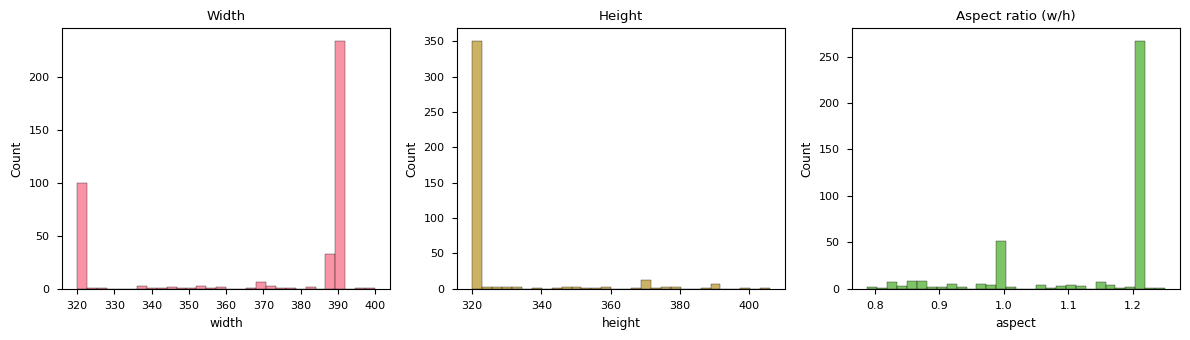

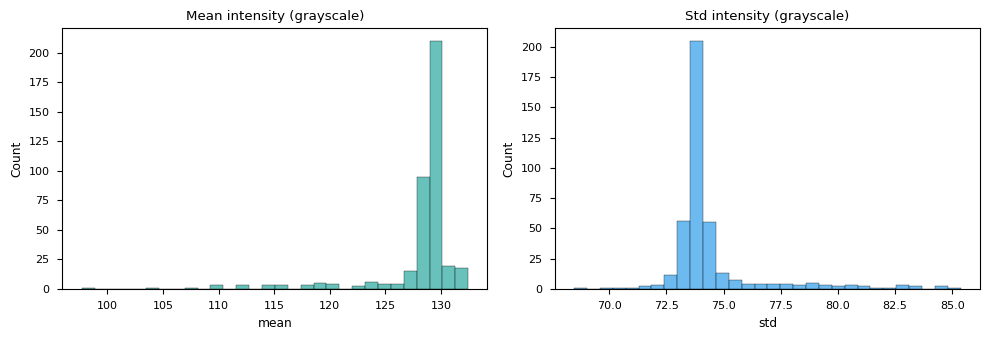

,count,mean,std,min,25%,50%,75%,max
width,400.0,369.932500,30.423954,320.000000,324.000000,390.000000,390.000000,400.000000
height,400.0,325.267500,16.049764,320.000000,320.000000,320.000000,320.000000,406.000000
aspect,400.0,1.141925,0.123469,0.788177,1.012500,1.218750,1.218750,1.250000
mean,400.0,128.106449,4.108463,97.683311,128.722595,129.082236,129.509205,132.432484
std,400.0,74.398151,2.074642,68.466024,73.600609,73.825267,74.167314,85.369484
min,400.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,400.0,255.000000,0.000000,255.000000,255.000000,255.000000,255.000000,255.000000


In [5]:
# Sample images and summarize file-level properties

SAMPLE_N = 400  # keep moderate

sample_paths = (df_train.select("Path")
                .where(F.col("Path").isNotNull())
                .orderBy(F.rand(seed=1))
                .limit(SAMPLE_N)
                .toPandas())

records = []
missing = 0
failed = 0

for s in sample_paths["Path"].tolist():
    p = resolve_image_path(s)
    if not p.exists():
        missing += 1
        continue
    try:
        arr = load_grayscale_uint8(p)
        h, w = arr.shape
        records.append({
            "path": str(p),
            "width": int(w),
            "height": int(h),
            "aspect": float(w) / float(h),
            "mean": float(arr.mean()),
            "std": float(arr.std()),
            "min": int(arr.min()),
            "max": int(arr.max()),
        })
    except Exception:
        failed += 1

img_df = pd.DataFrame(records)
print("Sampled rows:", SAMPLE_N)
print("Resolved images:", len(img_df))
print("Missing files:", missing)
print("Failed reads:", failed)

if img_df.empty:
    print("\nNo images were successfully resolved/loaded.")
    print("- This can happen if the image folders are not present locally, or if the config root points to the wrong directory.")
    print(f"- Config root_path: {CheXpert_data.config.data.raw.CheXpert.root_path}")
    print(f"- Config img_data:  {CheXpert_data.get_img_data_path()}")

    # Show a few example resolutions
    examples = []
    for s in sample_paths["Path"].head(10).tolist():
        p = resolve_image_path(s)
        examples.append({"csv_path": s, "resolved": str(p), "exists": bool(p.exists())})
    display(pd.DataFrame(examples))
else:
    # Dimension distributions
    fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))

    sns.histplot(img_df["width"], bins=30, ax=axes[0], color=sns.color_palette()[0])
    axes[0].set_title("Width")

    sns.histplot(img_df["height"], bins=30, ax=axes[1], color=sns.color_palette()[1])
    axes[1].set_title("Height")

    sns.histplot(img_df["aspect"], bins=30, ax=axes[2], color=sns.color_palette()[2])
    axes[2].set_title("Aspect ratio (w/h)")

    plt.tight_layout()
    plt.show()

    # Intensity stats
    fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

    sns.histplot(img_df["mean"], bins=30, ax=axes[0], color=sns.color_palette()[3])
    axes[0].set_title("Mean intensity (grayscale)")

    sns.histplot(img_df["std"], bins=30, ax=axes[1], color=sns.color_palette()[4])
    axes[1].set_title("Std intensity (grayscale)")

    plt.tight_layout()
    plt.show()

    display(img_df.describe().T)


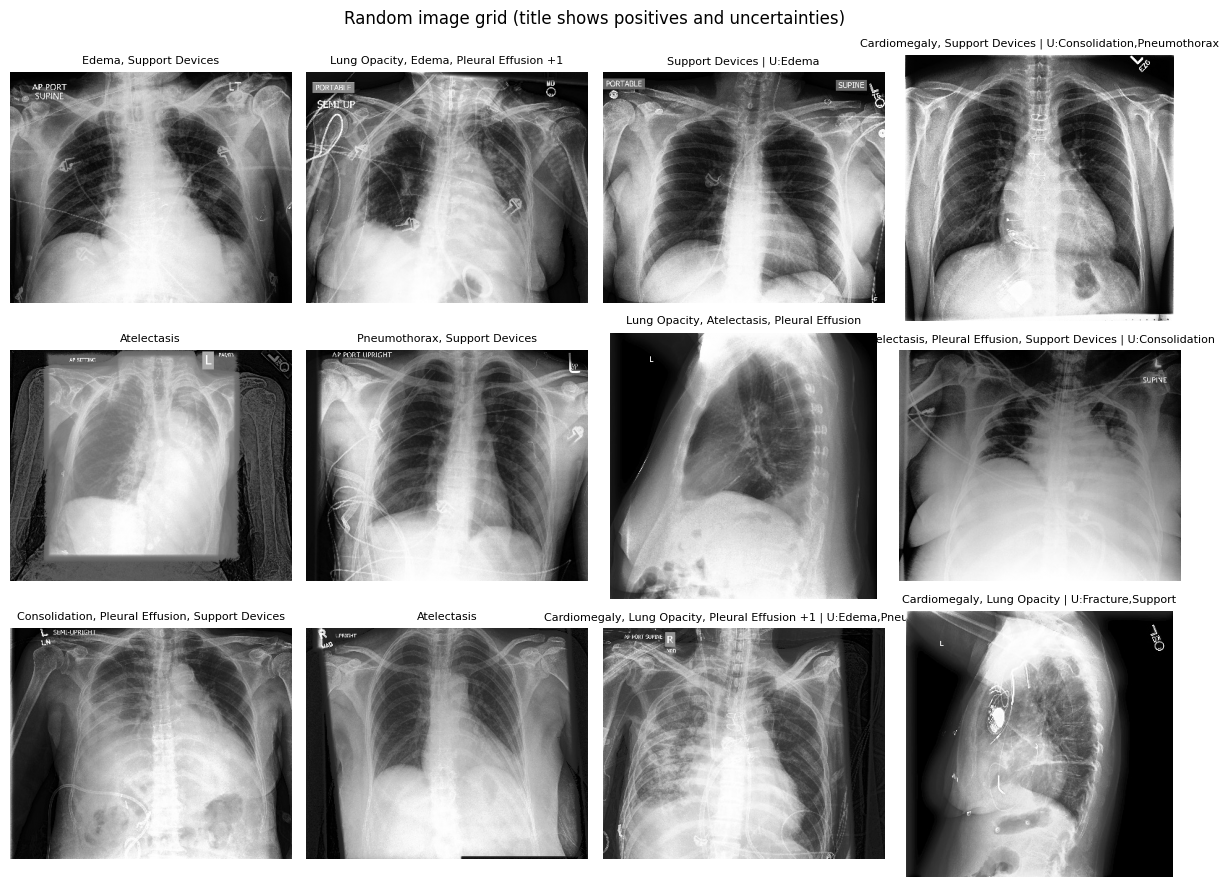

In [6]:
# Visual sanity-check: grid of random images with their label strings

GRID_N = 12

label_cols = [
    "No Finding", "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Opacity", "Lung Lesion", "Edema", "Consolidation",
    "Pneumonia", "Atelectasis", "Pneumothorax", "Pleural Effusion", "Pleural Other", "Fracture", "Support Devices"
]

grid_sample = (df_train.select(["Path", "Sex", "Age", "Frontal/Lateral", "AP/PA"] + label_cols)
               .where(F.col("Path").isNotNull())
               .orderBy(F.rand(seed=2))
               .limit(GRID_N)
               .toPandas())

fig, axes = plt.subplots(3, 4, figsize=(12, 9))
axes = axes.flatten()

for i, row in grid_sample.iterrows():
    p = resolve_image_path(row["Path"])
    ax = axes[i]
    if not p.exists():
        ax.axis("off")
        ax.set_title("missing file")
        continue

    try:
        arr = load_grayscale_uint8(p)
        ax.imshow(arr, cmap="gray")
        ax.axis("off")

        # Compact label string: show positives and uncertains only
        pos = [l for l in label_cols if row.get(l) == 1.0]
        unc = [l for l in label_cols if row.get(l) == -1.0]
        title = ", ".join(pos[:3])
        if len(pos) > 3:
            title += f" +{len(pos)-3}"
        if len(unc) > 0:
            title += (" | U:" + ",".join([u.split()[0] for u in unc[:2]]))

        ax.set_title(title, fontsize=8)
    except Exception:
        ax.axis("off")
        ax.set_title("read failed", fontsize=8)

# Hide unused axes if any
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.suptitle("Random image grid (title shows positives and uncertainties)")
plt.tight_layout()
plt.show()

In [7]:
# Summary Statistics
df_train.describe().show(5, truncate=False)

26/02/18 23:27:22 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+---------------------------------------------------------------+-------+------------------+---------------+------+----------+--------------------------+-------------------+------------------+------------------+------------------+--------------------+--------------------+---------------------+-------------------+------------------+-------------------+------------------+------------------+
|summary|Path                                                           |Sex    |Age               |Frontal/Lateral|AP/PA |No Finding|Enlarged Cardiomediastinum|Cardiomegaly       |Lung Opacity      |Lung Lesion       |Edema             |Consolidation       |Pneumonia           |Atelectasis          |Pneumothorax       |Pleural Effusion  |Pleural Other      |Fracture          |Support Devices   |
+-------+---------------------------------------------------------------+-------+------------------+---------------+------+----------+--------------------------+-------------------+------------------+

In [8]:
# Train data columns
df_train.printSchema()

root
 |-- Path: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Frontal/Lateral: string (nullable = true)
 |-- AP/PA: string (nullable = true)
 |-- No Finding: double (nullable = true)
 |-- Enlarged Cardiomediastinum: double (nullable = true)
 |-- Cardiomegaly: double (nullable = true)
 |-- Lung Opacity: double (nullable = true)
 |-- Lung Lesion: double (nullable = true)
 |-- Edema: double (nullable = true)
 |-- Consolidation: double (nullable = true)
 |-- Pneumonia: double (nullable = true)
 |-- Atelectasis: double (nullable = true)
 |-- Pneumothorax: double (nullable = true)
 |-- Pleural Effusion: double (nullable = true)
 |-- Pleural Other: double (nullable = true)
 |-- Fracture: double (nullable = true)
 |-- Support Devices: double (nullable = true)



In [9]:
# Count entries in the dataset
df_train.count()

223414

In [10]:
# Null counts per column
null_counts = df_train.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c)
    for c in df_train.columns
]).show(truncate=False)

+----+---+---+---------------+-----+----------+--------------------------+------------+------------+-----------+------+-------------+---------+-----------+------------+----------------+-------------+--------+---------------+
|Path|Sex|Age|Frontal/Lateral|AP/PA|No Finding|Enlarged Cardiomediastinum|Cardiomegaly|Lung Opacity|Lung Lesion|Edema |Consolidation|Pneumonia|Atelectasis|Pneumothorax|Pleural Effusion|Pleural Other|Fracture|Support Devices|
+----+---+---+---------------+-----+----------+--------------------------+------------+------------+-----------+------+-------------+---------+-----------+------------+----------------+-------------+--------+---------------+
|0   |0  |0  |0              |32387|201033    |178575                    |177211      |105636      |211470     |137458|152792       |195806   |154971     |144480      |90203           |216922       |211220  |100197         |
+----+---+---+---------------+-----+----------+--------------------------+------------+------------+

In [11]:
# Distinct Values for Categorical columns
for c in ["Sex", "Frontal/Lateral", "AP/PA"]:
    df_train.select(c).distinct().show(truncate=False)

+-------+
|Sex    |
+-------+
|Female |
|Male   |
|Unknown|
+-------+

+---------------+
|Frontal/Lateral|
+---------------+
|Lateral        |
|Frontal        |
+---------------+

+-----+
|AP/PA|
+-----+
|LL   |
|PA   |
|AP   |
|RL   |
|NULL |
+-----+



#### Label semantics exploration
CheXpert labels are:
+ 1.0 -> `positive`
+ 0.0 -> `negative`
+ -1.0 -> `uncertain`
+ null -> `not mentioned`

In [12]:
# Frequency distribution per label

for label in label_cols:
    print("\n{}".format(label))
    df_train.groupBy(label).count().orderBy(label).show(truncate=False)


No Finding
+----------+------+
|No Finding|count |
+----------+------+
|NULL      |201033|
|1.0       |22381 |
+----------+------+


Enlarged Cardiomediastinum
+--------------------------+------+
|Enlarged Cardiomediastinum|count |
+--------------------------+------+
|NULL                      |178575|
|-1.0                      |12403 |
|0.0                       |21638 |
|1.0                       |10798 |
+--------------------------+------+


Cardiomegaly
+------------+------+
|Cardiomegaly|count |
+------------+------+
|NULL        |177211|
|-1.0        |8087  |
|0.0         |11116 |
|1.0         |27000 |
+------------+------+


Lung Opacity
+------------+------+
|Lung Opacity|count |
+------------+------+
|NULL        |105636|
|-1.0        |5598  |
|0.0         |6599  |
|1.0         |105581|
+------------+------+


Lung Lesion
+-----------+------+
|Lung Lesion|count |
+-----------+------+
|NULL       |211470|
|-1.0       |1488  |
|0.0        |1270  |
|1.0        |9186  |
+-------

In [13]:
# Positive Prevalence %
total = df_train.count()

for label in label_cols:
    positive = df_train.filter(F.col(label) == 1.0).count()
    print(label, positive / total)

No Finding 0.10017724941140663
Enlarged Cardiomediastinum 0.048331796574968444
Cardiomegaly 0.12085187141360881
Lung Opacity 0.47258005317482343
Lung Lesion 0.041116492252052245
Edema 0.2338528471805706
Consolidation 0.0661686375965696
Pneumonia 0.027030535239510507
Atelectasis 0.14939081704817067
Pneumothorax 0.08704915537969868
Pleural Effusion 0.38577260153795195
Pleural Other 0.01576893122185718
Fracture 0.040462996947371245
Support Devices 0.5192199235500013


In [14]:
# Uncertainty ratio per label
for label in label_cols:
    uncertain = df_train.filter(F.col(label) == -1.0).count()
    print(label, uncertain / total)

No Finding 0.0
Enlarged Cardiomediastinum 0.05551576893122186
Cardiomegaly 0.03619737348599461
Lung Opacity 0.025056621339754895
Lung Lesion 0.006660280913461108
Edema 0.058116322164233215
Consolidation 0.12417305987986428
Pneumonia 0.08401443060864583
Atelectasis 0.15101560331939806
Pneumothorax 0.014077005022066656
Pleural Effusion 0.05204687262212753
Pleural Other 0.011874815365196452
Fracture 0.002873588942501365
Support Devices 0.0048295988613068115


In [15]:
# Multi label density per image
positive_sum_expr = " + ".join([
    f"IF(`{l}`= 1.0, 1, 0)" for l in label_cols 
])

df_train = df_train.withColumn(
    "num_positive", F.expr(positive_sum_expr)
)

df_train.groupBy("num_positive").count()

DataFrame[num_positive: int, count: bigint]

In [16]:
# Co-occurrence (Edema & Cardiomegaly)
df_train.filter(
    (F.col("Edema") == 1.0) & (F.col("Cardiomegaly") == 1.0)
).count()

11659

Demographic Confounders

In [17]:
df_train.groupBy("Age").count().orderBy("Age").show(truncate=False)

+---+-----+
|Age|count|
+---+-----+
|0  |3    |
|18 |766  |
|19 |1167 |
|20 |1287 |
|21 |1279 |
|22 |1370 |
|23 |1229 |
|24 |1388 |
|25 |1326 |
|26 |1338 |
|27 |1535 |
|28 |1344 |
|29 |1312 |
|30 |1637 |
|31 |1493 |
|32 |1327 |
|33 |1400 |
|34 |1415 |
|35 |1534 |
|36 |1549 |
+---+-----+
only showing top 20 rows


In [18]:
df_train.select("Age").describe().show()

+-------+------------------+
|summary|               Age|
+-------+------------------+
|  count|            223414|
|   mean|60.430653405784774|
| stddev|  17.8209246640007|
|    min|                 0|
|    max|                90|
+-------+------------------+



In [19]:
# Disease prevalence by sex
df_train.groupBy("Sex").agg(
    F.sum(F.when(F.col("Pneumothorax") == 1.0, 1).otherwise(0)).alias("positive")
).show(truncate=False)

+-------+--------+
|Sex    |positive|
+-------+--------+
|Female |7503    |
|Male   |11945   |
|Unknown|0       |
+-------+--------+



In [20]:
# Distribution of views
df_train.groupBy("Frontal/Lateral").count().show()
df_train.groupBy("AP/PA").count().show()

+---------------+------+
|Frontal/Lateral| count|
+---------------+------+
|        Lateral| 32387|
|        Frontal|191027|
+---------------+------+

+-----+------+
|AP/PA| count|
+-----+------+
| NULL| 32387|
|   LL|    16|
|   PA| 29420|
|   AP|161590|
|   RL|     1|
+-----+------+



In [21]:
# Disease prevalence by view
df_train.groupBy("AP/PA").agg(
    F.sum(F.when(F.col("Edema") == 1.0, 1).otherwise(0)).alias("edema_pos")
).show()

+-----+---------+
|AP/PA|edema_pos|
+-----+---------+
| NULL|     2571|
|   LL|        1|
|   PA|     1709|
|   AP|    47965|
|   RL|        0|
+-----+---------+



In [22]:
""" No finding `Semantics Check` """

# Create a list of boolean expressions
other_labels = [(F.col(l) == 1.0) for l in label_cols if l != "No Finding"]

df_train.filter(
    (F.col("No Finding") == 1.0) & 
    reduce(or_, other_labels)
).count()

8808

In [23]:
# Path column inspection (patient-level identifiers)
# Example: CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg
# split('/') => [dataset_root, split, patient_id, study_id, image_file]

df_train = (df_train
    .withColumn("patient_id", F.split(F.col("Path"), "/").getItem(2))
    .withColumn("study_id", F.split(F.col("Path"), "/").getItem(3))
)

print("Unique patients:", df_train.select("patient_id").distinct().count())
print("Unique studies:", df_train.select("patient_id", "study_id").distinct().count())

(df_train.groupBy("patient_id")
 .count()
 .orderBy("count", ascending=False)
 .show(20, truncate=False)
)


Unique patients: 64540


Unique studies: 187641
+------------+-----+
|patient_id  |count|
+------------+-----+
|patient28746|92   |
|patient33155|92   |
|patient04462|89   |
|patient24163|86   |
|patient34615|85   |
|patient19317|80   |
|patient05702|79   |
|patient13011|79   |
|patient14282|77   |
|patient06028|76   |
|patient03122|76   |
|patient10970|76   |
|patient26381|76   |
|patient20479|75   |
|patient30627|74   |
|patient09793|73   |
|patient13162|72   |
|patient19689|72   |
|patient31471|72   |
|patient24428|71   |
+------------+-----+
only showing top 20 rows


### Semantic label exploration (train set)

CheXpert label values encode *semantics* beyond binary disease presence:
- `1.0` = positive
- `0.0` = negative
- `-1.0` = uncertain
- `null` = not mentioned

The plots below summarize **(a)** state composition per label, **(b)** positive prevalence, **(c)** uncertainty rates, and **(d)** multi-label cardinality.


<Figure size 600x400 with 0 Axes>

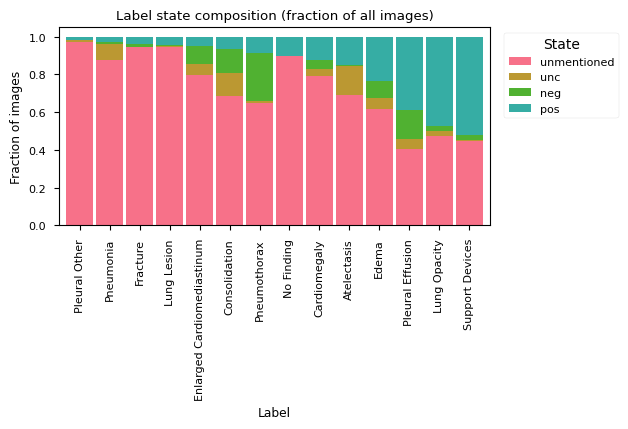

In [ ]:
# Label state composition + prevalence + uncertainty (plots)

total = df_train.count()

rows = []
for l in label_cols:
    r = (df_train
         .agg(
             F.sum(F.when(F.col(l) == 1.0, 1).otherwise(0)).alias("pos"),
             F.sum(F.when(F.col(l) == 0.0, 1).otherwise(0)).alias("neg"),
             F.sum(F.when(F.col(l) == -1.0, 1).otherwise(0)).alias("unc"),
             F.sum(F.when(F.col(l).isNull(), 1).otherwise(0)).alias("unmentioned"),
         )
         .collect()[0]
    )
    rows.append({
        "label": l,
        "pos": int(r["pos"]),
        "neg": int(r["neg"]),
        "unc": int(r["unc"]),
        "unmentioned": int(r["unmentioned"]),
    })

state_df = pd.DataFrame(rows)
state_df["pos_rate"] = state_df["pos"] / total
state_df["unc_rate"] = state_df["unc"] / total

# Order labels by positive prevalence (ascending)
state_df = state_df.sort_values("pos_rate", ascending=True).reset_index(drop=True)

# Stacked state composition per label
state_pct = state_df.set_index("label")[["unmentioned", "unc", "neg", "pos"]] / total

plt.figure(figsize=(6, 4))
state_pct.plot(kind="bar", stacked=True, width=0.9)
plt.title("Label state composition (fraction of all images)")
plt.xlabel("Label")
plt.ylabel("Fraction of images")
plt.legend(title="State", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

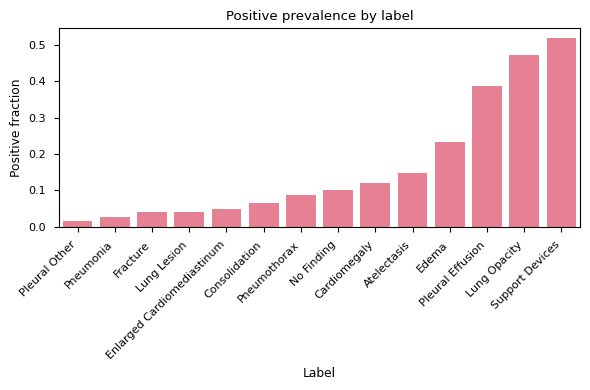

In [25]:
# Positive prevalence
plt.figure(figsize=(6, 4))
sns.barplot(data=state_df, x="label", y="pos_rate", color=sns.color_palette()[0])
plt.title("Positive prevalence by label")
plt.xlabel("Label")
plt.ylabel("Positive fraction")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

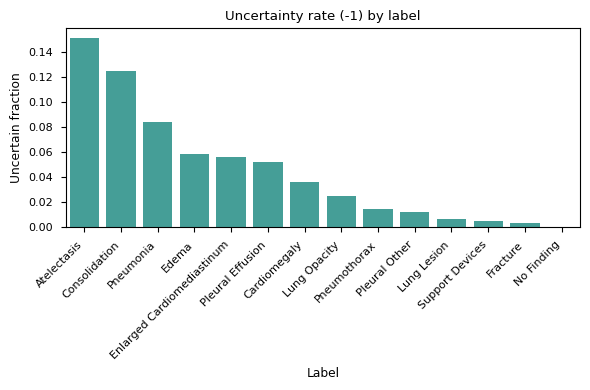

,label,pos_rate,unc_rate
0,Pleural Other,0.015769,0.011875
1,Pneumonia,0.027031,0.084014
2,Fracture,0.040463,0.002874
3,Lung Lesion,0.041116,0.006660
4,Enlarged Cardiomediastinum,0.048332,0.055516
5,Consolidation,0.066169,0.124173
6,Pneumothorax,0.087049,0.014077
7,No Finding,0.100177,0.000000
8,Cardiomegaly,0.120852,0.036197
9,Atelectasis,0.149391,0.151016


In [40]:
# Uncertainty rates
plt.figure(figsize=(6, 4))
state_df_unc = state_df.sort_values("unc_rate", ascending=False)
sns.barplot(data=state_df_unc, x="label", y="unc_rate", color=sns.color_palette()[3])
plt.title("Uncertainty rate (-1) by label")
plt.xlabel("Label")
plt.ylabel("Uncertain fraction")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

state_df[["label", "pos_rate", "unc_rate"]]

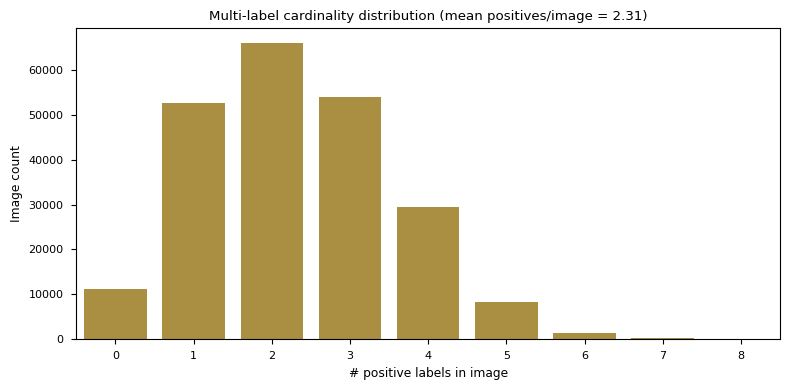

Expected positive labels / image (all labels, incl. No Finding + Support Devices): 2.31
Expected positive labels / image (excluding No Finding + Support Devices): 1.69


In [27]:
# Multi-label cardinality (how many positive labels per image?)

if "num_positive" not in df_train.columns:
    positive_sum_expr = " + ".join([f"IF(`{l}`= 1.0, 1, 0)" for l in label_cols])
    df_train = df_train.withColumn("num_positive", F.expr(positive_sum_expr))

card_df = (df_train.groupBy("num_positive")
           .count()
           .orderBy("num_positive")
           .toPandas())

mean_pos = df_train.agg(F.mean("num_positive").alias("mean")).collect()[0]["mean"]

plt.figure(figsize=(8, 4))
sns.barplot(data=card_df, x="num_positive", y="count", color=sns.color_palette()[1])
plt.title(f"Multi-label cardinality distribution (mean positives/image = {mean_pos:.2f})")
plt.xlabel("# positive labels in image")
plt.ylabel("Image count")
plt.tight_layout()
plt.show()

# Expected positives/image by summing per-label positive rates
expected_pos_all = state_df["pos_rate"].sum()
expected_pos_findings_only = state_df.loc[~state_df["label"].isin(["No Finding", "Support Devices"]), "pos_rate"].sum()

print(f"Expected positive labels / image (all labels, incl. No Finding + Support Devices): {expected_pos_all:.2f}")
print(f"Expected positive labels / image (excluding No Finding + Support Devices): {expected_pos_findings_only:.2f}")


No Finding positives: 22381
Contradictions (No Finding==1 and some other label==1): 8808
Contradiction rate among No Finding positives: 0.3935480988338323
Contradiction rate among all images: 0.03942456605226172


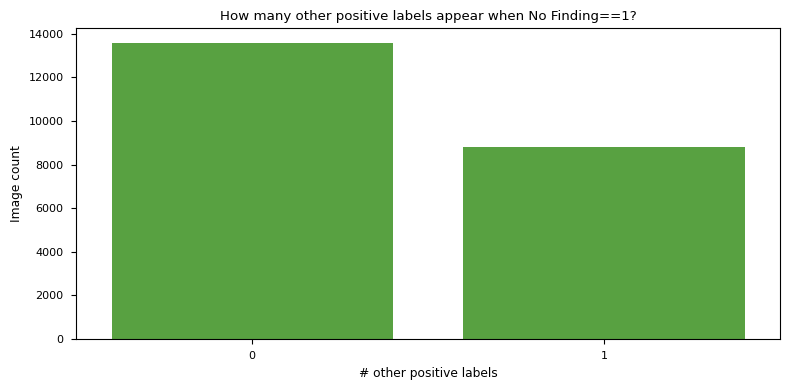

,num_other_positives,count
0,0,13573
1,1,8808


In [28]:
# "No Finding" label noise: contradictions and co-label density

other_pos = [(F.col(l) == 1.0) for l in label_cols if l != "No Finding"]
contradictions = df_train.filter((F.col("No Finding") == 1.0) & reduce(or_, other_pos)).count()
no_finding_pos = df_train.filter(F.col("No Finding") == 1.0).count()

print("No Finding positives:", no_finding_pos)
print("Contradictions (No Finding==1 and some other label==1):", contradictions)
print("Contradiction rate among No Finding positives:", contradictions / max(no_finding_pos, 1))
print("Contradiction rate among all images:", contradictions / total)

# How many other positives accompany No Finding==1?
other_positive_sum_expr = " + ".join([f"IF(`{l}`= 1.0, 1, 0)" for l in label_cols if l != "No Finding"])

nf_df = (df_train
         .withColumn("num_other_positives", F.expr(other_positive_sum_expr))
         .filter(F.col("No Finding") == 1.0)
         .groupBy("num_other_positives")
         .count()
         .orderBy("num_other_positives")
         .toPandas())

plt.figure(figsize=(8, 4))
sns.barplot(data=nf_df, x="num_other_positives", y="count", color=sns.color_palette()[2])
plt.title("How many other positive labels appear when No Finding==1?")
plt.xlabel("# other positive labels")
plt.ylabel("Image count")
plt.tight_layout()
plt.show()

nf_df


### Label co-occurrence (pipeline readiness)

Co-occurrence helps decide whether to:
- model labels independently vs exploit dependencies,
- expect common multi-label bundles,
- sanity-check implausible pairs,
- design stratified splits (e.g., preserve co-occurrence structure).


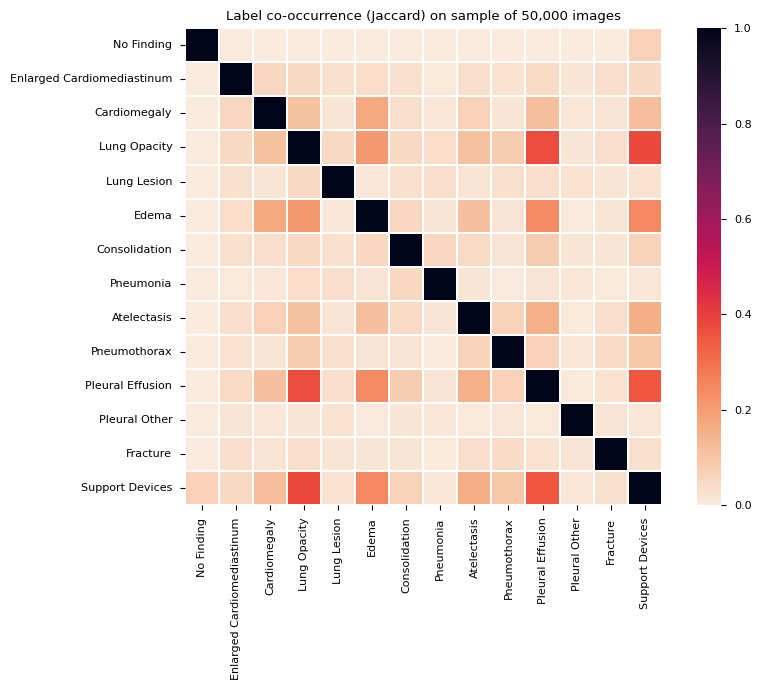

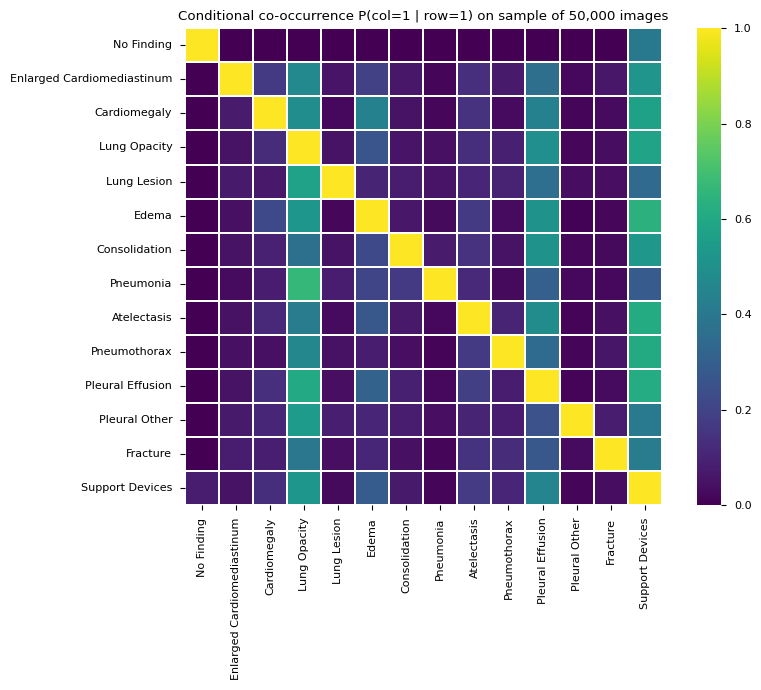

,A,B,jaccard,co_pos_count
45,Lung Opacity,Support Devices,0.379801,13677
42,Lung Opacity,Pleural Effusion,0.372894,11644
87,Pleural Effusion,Support Devices,0.353787,11854
62,Edema,Support Devices,0.246728,7485
59,Edema,Pleural Effusion,0.238624,5973
37,Lung Opacity,Edema,0.210912,6154
27,Cardiomegaly,Edema,0.172788,2611
80,Atelectasis,Support Devices,0.156365,4531
77,Atelectasis,Pleural Effusion,0.155461,3591
35,Cardiomegaly,Support Devices,0.119885,3434


In [29]:
# Co-occurrence heatmap (Jaccard + conditional probabilities) on a sampled subset

COOC_SAMPLE_N = 50000

# sample a manageable subset then convert to pandas
sub = (df_train.select([F.when(F.col(l) == 1.0, 1).otherwise(0).alias(l) for l in label_cols])
       .orderBy(F.rand(seed=3))
       .limit(COOC_SAMPLE_N)
       .toPandas())

X = sub[label_cols].to_numpy(dtype=np.int32)
co = X.T @ X  # counts of (i=1 and j=1)

pos = np.diag(co).astype(np.float64)

# Jaccard(i,j) = P(i&j) / P(i|j)
union = pos[:, None] + pos[None, :] - co
jacc = np.divide(co, union, out=np.zeros_like(co, dtype=np.float64), where=union != 0)

# Conditional P(j=1 | i=1)
cond = np.divide(co, pos[:, None], out=np.zeros_like(co, dtype=np.float64), where=pos[:, None] != 0)

jacc_df = pd.DataFrame(jacc, index=label_cols, columns=label_cols)
cond_df = pd.DataFrame(cond, index=label_cols, columns=label_cols)

plt.figure(figsize=(9, 7))
sns.heatmap(jacc_df, cmap="rocket_r", square=True, linewidths=0.25)
plt.title(f"Label co-occurrence (Jaccard) on sample of {len(sub):,} images")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 7))
sns.heatmap(cond_df, cmap="viridis", square=True, linewidths=0.25)
plt.title(f"Conditional co-occurrence P(col=1 | row=1) on sample of {len(sub):,} images")
plt.tight_layout()
plt.show()

# Show strongest off-diagonal Jaccard pairs
pairs = []
for i,a in enumerate(label_cols):
    for j,b in enumerate(label_cols):
        if i >= j:
            continue
        pairs.append((a, b, jacc_df.iloc[i, j], int(co[i, j])))

pairs_df = (pd.DataFrame(pairs, columns=["A", "B", "jaccard", "co_pos_count"])
            .sort_values(["jaccard", "co_pos_count"], ascending=False)
            .head(20))

pairs_df


### Demographics & acquisition confounders

Below we check whether **patient demographics** (sex, age) and **acquisition factors** (view) correlate with label frequencies.


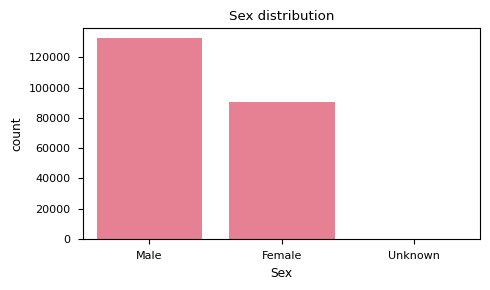

In [30]:
# Sex distribution 

sex_counts = (df_train.groupBy("Sex").count().orderBy("count", ascending=False).toPandas())
plt.figure(figsize=(5, 3))
sns.barplot(data=sex_counts, x="Sex", y="count", color=sns.color_palette()[0])
plt.title("Sex distribution")
plt.tight_layout()
plt.show()

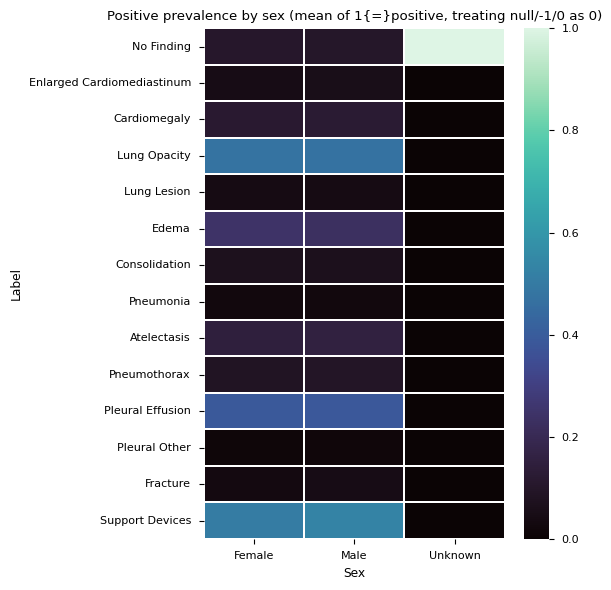

,Sex,n,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
1,Male,132636,0.098849,0.051540,0.124220,0.470061,0.040532,0.226726,0.065736,0.026818,0.152696,0.090059,0.384300,0.016828,0.044747,0.527971
0,Female,90777,0.102107,0.043645,0.115932,0.476266,0.041971,0.244269,0.066801,0.027342,0.144563,0.082653,0.387929,0.014222,0.034205,0.506439
2,Unknown,1,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [31]:
# Label prevalence by sex (heatmap)
sex_prev = (df_train.groupBy("Sex")
            .agg(
                F.count("*").alias("n"),
                *[F.mean(F.when(F.col(l) == 1.0, 1).otherwise(0)).alias(l) for l in label_cols]
            )
            .toPandas())

sex_prev_long = sex_prev.melt(id_vars=["Sex", "n"], var_name="label", value_name="pos_rate")
sex_prev_pivot = sex_prev_long.pivot(index="label", columns="Sex", values="pos_rate").loc[label_cols]

plt.figure(figsize=(6, 6))
sns.heatmap(sex_prev_pivot, cmap="mako", linewidths=0.25)
plt.title("Positive prevalence by sex (mean of 1{=}positive, treating null/-1/0 as 0)")
plt.xlabel("Sex")
plt.ylabel("Label")
plt.tight_layout()
plt.show()

sex_prev.sort_values("n", ascending=False)

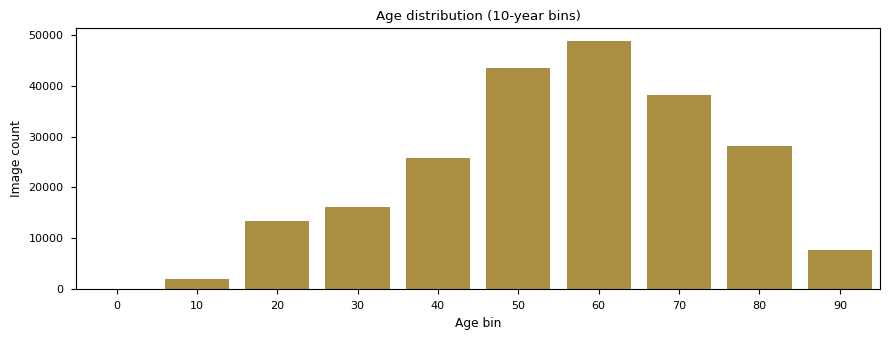

In [32]:
# Age distribution prevalence by age bins

age_valid = df_train.filter(F.col("Age").isNotNull())

age_bins = (age_valid
            .withColumn("age_bin", (F.floor(F.col("Age") / 10) * 10).cast("int"))
            .groupBy("age_bin")
            .count()
            .orderBy("age_bin")
            .toPandas())

plt.figure(figsize=(9, 3.5))
sns.barplot(data=age_bins, x="age_bin", y="count", color=sns.color_palette()[1])
plt.title("Age distribution (10-year bins)")
plt.xlabel("Age bin")
plt.ylabel("Image count")
plt.tight_layout()
plt.show()

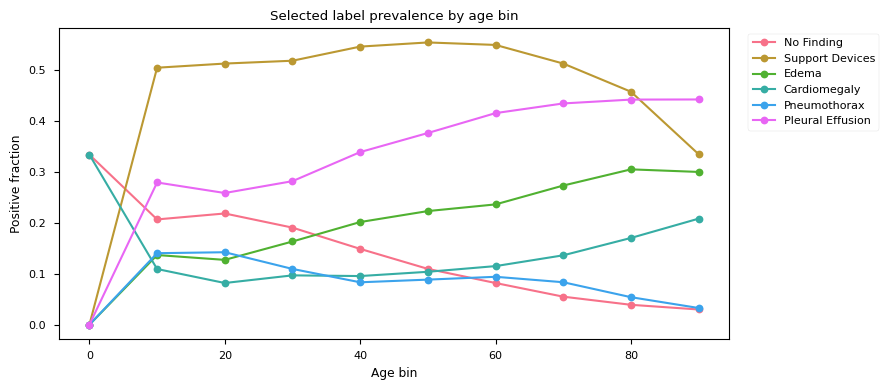

,age_bin,No Finding,Support Devices,Edema,Cardiomegaly,Pneumothorax,Pleural Effusion
0,0,0.333333,0.000000,0.000000,0.333333,0.000000,0.000000
1,10,0.206415,0.503880,0.136575,0.109157,0.140197,0.278841
2,20,0.218079,0.512008,0.127088,0.081742,0.142079,0.258204
3,30,0.190322,0.517585,0.163133,0.096720,0.109317,0.281429
4,40,0.148621,0.545268,0.201286,0.095376,0.083140,0.338445
5,50,0.109413,0.553418,0.222785,0.103728,0.088377,0.375857
6,60,0.081715,0.548540,0.235878,0.114880,0.093930,0.414878
7,70,0.054936,0.512003,0.272844,0.136055,0.083244,0.433822
8,80,0.038990,0.456771,0.304573,0.170078,0.053926,0.441374
9,90,0.029819,0.334213,0.299512,0.207943,0.032722,0.441615


In [41]:
# Label prevalence by age bin (selected labels)
selected = ["No Finding", "Support Devices", "Edema", "Cardiomegaly", "Pneumothorax", "Pleural Effusion"]

age_prev = (age_valid
            .withColumn("age_bin", (F.floor(F.col("Age") / 10) * 10).cast("int"))
            .groupBy("age_bin")
            .agg(*[F.mean(F.when(F.col(l) == 1.0, 1).otherwise(0)).alias(l) for l in selected])
            .orderBy("age_bin")
            .toPandas())

plt.figure(figsize=(9, 4))
for l in selected:
    plt.plot(age_prev["age_bin"], age_prev[l], marker="o", linewidth=1.5, label=l)
    
plt.title("Selected label prevalence by age bin")
plt.xlabel("Age bin")
plt.ylabel("Positive fraction")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

age_prev

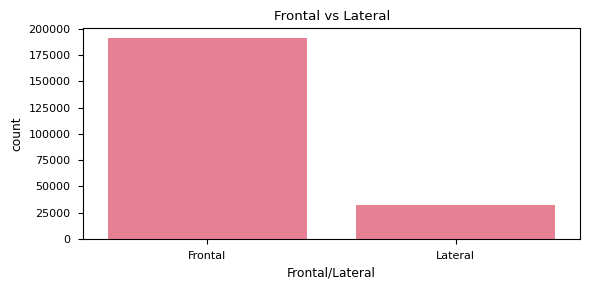

In [34]:
# View distribution + potential confounding

view_counts = (df_train.groupBy("Frontal/Lateral").count().orderBy("count", ascending=False).toPandas())
plt.figure(figsize=(6, 3))
sns.barplot(data=view_counts, x="Frontal/Lateral", y="count", color=sns.color_palette()[0])
plt.title("Frontal vs Lateral")
plt.tight_layout()
plt.show()

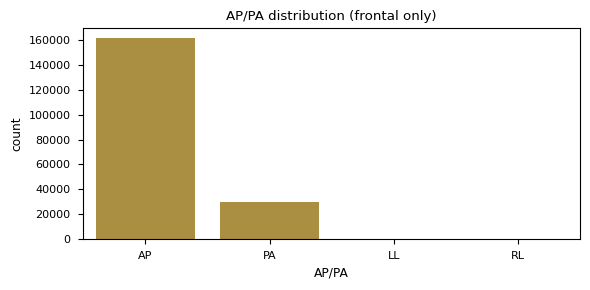

In [35]:

# AP/PA is only defined for frontal images (lateral typically has AP/PA = null)
frontal = df_train.filter(F.col("Frontal/Lateral") == "Frontal")
ap_counts = (frontal.groupBy("AP/PA").count().orderBy("count", ascending=False).toPandas())
plt.figure(figsize=(6, 3))
sns.barplot(data=ap_counts, x="AP/PA", y="count", color=sns.color_palette()[1])
plt.title("AP/PA distribution (frontal only)")
plt.tight_layout()
plt.show()

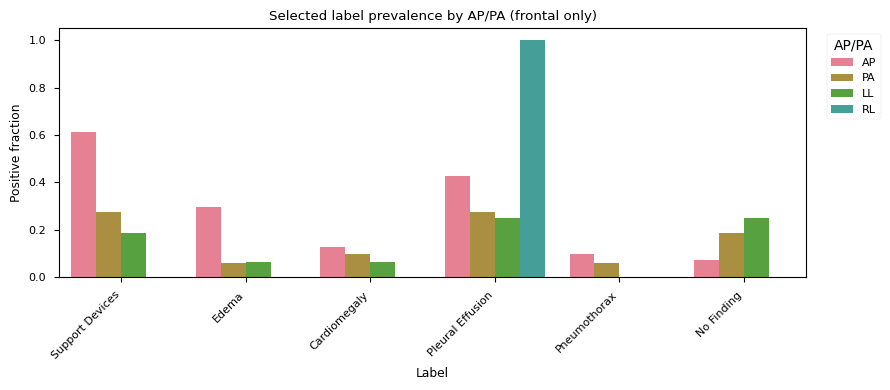

,AP/PA,n,Support Devices,Edema,Cardiomegaly,Pleural Effusion,Pneumothorax,No Finding
0,AP,161590,0.612835,0.296831,0.126710,0.425868,0.098341,0.070988
1,PA,29420,0.276649,0.058090,0.098878,0.274575,0.061251,0.186914
2,LL,16,0.187500,0.062500,0.062500,0.250000,0.000000,0.250000
3,RL,1,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000


In [36]:
# Prevalence by AP/PA for selected labels
selected_view = ["Support Devices", "Edema", "Cardiomegaly", "Pleural Effusion", "Pneumothorax", "No Finding"]
view_prev = (frontal.groupBy("AP/PA")
             .agg(
                 F.count("*").alias("n"),
                 *[F.mean(F.when(F.col(l) == 1.0, 1).otherwise(0)).alias(l) for l in selected_view]
             )
             .orderBy("n", ascending=False)
             .toPandas())

view_prev_long = view_prev.melt(id_vars=["AP/PA", "n"], var_name="label", value_name="pos_rate")
plt.figure(figsize=(9, 4))
sns.barplot(data=view_prev_long, x="label", y="pos_rate", hue="AP/PA")
plt.title("Selected label prevalence by AP/PA (frontal only)")
plt.xlabel("Label")
plt.ylabel("Positive fraction")
plt.xticks(rotation=45, ha="right")
plt.legend(title="AP/PA", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

view_prev

### Patient-level leakage risk

CheXpert contains **multiple images per patient** (and per study). If you split *by image*, you can leak patient-specific signals across train/val/test.


Patients: 64540
Mean images/patient: 3.461636194607995
p50/p90/p99 images/patient: [2, 7, 23]
Max images/patient: 92


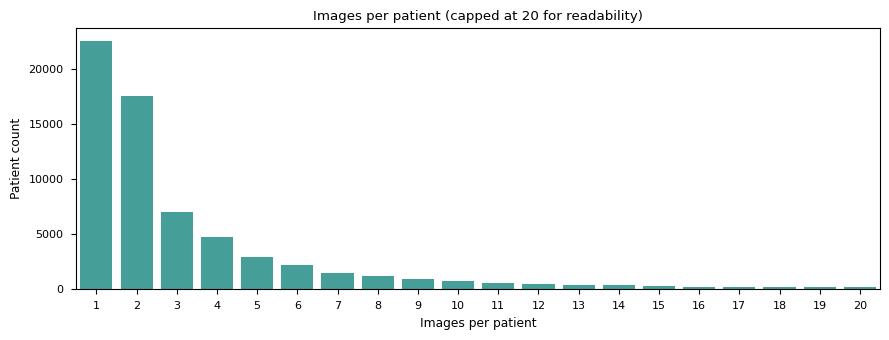

,images,count
69,74,1
70,75,1
71,76,4
72,77,1
73,79,2
74,80,1
75,85,1
76,86,1
77,89,1
78,92,2


In [37]:
# Images-per-patient distribution

per_patient = (df_train.groupBy("patient_id").count().withColumnRenamed("count", "images") )

summary = per_patient.agg(
    F.count("*").alias("n_patients"),
    F.mean("images").alias("mean_images"),
    F.expr("percentile_approx(images, array(0.5, 0.9, 0.99))").alias("p50_p90_p99"),
    F.max("images").alias("max_images"),
).collect()[0]

print("Patients:", summary["n_patients"])
print("Mean images/patient:", float(summary["mean_images"]))
print("p50/p90/p99 images/patient:", summary["p50_p90_p99"])
print("Max images/patient:", int(summary["max_images"]))

hist = (per_patient.groupBy("images").count().orderBy("images").toPandas())

plt.figure(figsize=(9, 3.5))
sns.barplot(data=hist[hist["images"] <= 20], x="images", y="count", color=sns.color_palette()[3])
plt.title("Images per patient (capped at 20 for readability)")
plt.xlabel("Images per patient")
plt.ylabel("Patient count")
plt.tight_layout()
plt.show()

hist.tail(10)


#### Strategy: how to deal with CheXpert (based on findings)

##### Splitting / evaluation protocol
- **Split by `patient_id`** (group split) to avoid leakage.
- Consider an additional **study-level constraint** (keep studies within the same patient on one side).
- Report metrics per label (e.g., **AUROC + AUPRC**) and macro averages; prevalence is low for several labels.

##### Label handling (semantic values)
- Treat each label as 4-state: {positive, negative, uncertain, unmentioned}.
- Choose an **uncertainty policy** and keep it consistent across train/val/test:
  - **U-Ignore**: drop uncertain from loss for that label (mask it).
  - **U-Zeros / U-Ones**: map uncertain to 0 or 1 (task-dependent; can bias).
  - **Soft targets**: map uncertain to a probability (e.g., 0.5 or label-specific priors).
- For `null` (*not mentioned*), decide whether it should be treated as **negative** or **missing** (often missing);
  - If treated as negative, you effectively train a *mention* model, not necessarily a disease model.

##### "No Finding" noise
- The notebook shows **non-trivial contradictions** where `No Finding==1` but some other label is positive.
- Options:
  - Use `No Finding` as a **derived label**: `NoFinding = 1` iff all other findings are not positive.
  - Or **exclude `No Finding`** from targets and derive it at inference.

##### Confounders (view + devices)
- **View (AP/PA)** is strongly associated with some labels (e.g., edema) → treat as a confounder.
- Mitigations:
  - Add view as a **covariate** (metadata feature), or
  - **Stratify** splits by view, or
  - Train/evaluate on a **restricted subset** (e.g., frontal PA only) for fair comparisons.
- `Support Devices` can act as a proxy for ICU/acuity; consider whether to include it or treat it separately.

##### Imbalance & training
- Use **per-label loss weighting** (inverse prevalence), **focal loss**, or **balanced sampling**.
- Track label-wise performance; rare labels (e.g., Pleural Other) will need special care.

##### Data pipeline hygiene
- Validate schema, enforce consistent dtypes, and keep a reproducible preprocessing pipeline.
- Save aggregated EDA artifacts (plots + tables) as outputs so changes across dataset versions are visible.
